In [1]:
import pandas
import numpy as np
from utils import *
import mne
import matplotlib.pyplot as plt
from os import walk
from sklearn.decomposition import FastICA
from sklearn.naive_bayes import GaussianNB, MultinomialNB
from sklearn.model_selection import cross_val_score
from itertools import combinations
from sklearn.preprocessing import normalize
from sklearn.utils import shuffle
from tqdm.notebook import tqdm
import pickle

from multiprocessing import Pool
plt.style.use('seaborn-whitegrid')

# Groud truth - Median

In [2]:
df = pandas.read_csv('./HEXACO.csv')
# Honesty-Humility	Emotionality	eXtraversion	Agreeableness	Conscientiousness	Openness to Experience
gt = df[['id','Honesty-Humility','Emotionality','eXtraversion','Agreeableness','Conscientiousness','Openness to Experience']].rename(columns={'Honesty-Humility':'h',
                                  'Emotionality':'e',
                                  'eXtraversion':'x',
                                 'Agreeableness':'a',
                             'Conscientiousness':'c',
                        'Openness to Experience':'o'}).set_index('id')

gt['lh'] = (gt[['h']] > np.median(gt['h'])) * 1
gt['le'] = (gt[['e']] > np.median(gt['e'])) * 1
gt['lx'] = (gt[['x']] > np.median(gt['x'])) * 1
gt['la'] = (gt[['a']] > np.median(gt['a'])) * 1
gt['lc'] = (gt[['c']] > np.median(gt['c'])) * 1
gt['lo'] = (gt[['o']] > np.median(gt['o'])) * 1
gt

,h,e,x,a,c,o,lh,le,lx,la,lc,lo
id,,,,,,,,,,,,
2,3.63,3.19,2.94,2.38,3.38,2.38,1,0,0,0,0,0
3,3.38,3.44,3.50,3.50,4.50,3.81,0,0,1,1,1,1
4,3.19,3.75,3.69,3.19,2.63,2.63,0,1,1,0,0,0
5,3.25,3.63,2.13,3.56,3.63,2.31,0,1,0,1,1,0
6,3.25,2.75,3.50,2.50,3.75,5.00,0,0,1,0,1,1
7,4.06,3.06,3.38,2.88,2.50,4.19,1,0,1,0,0,1
8,3.94,2.94,3.19,3.75,3.38,3.81,1,0,1,1,0,1
9,4.44,4.00,3.38,3.75,3.69,3.31,1,1,1,1,1,0
10,3.63,3.25,3.50,3.31,3.88,2.69,1,0,1,1,1,0


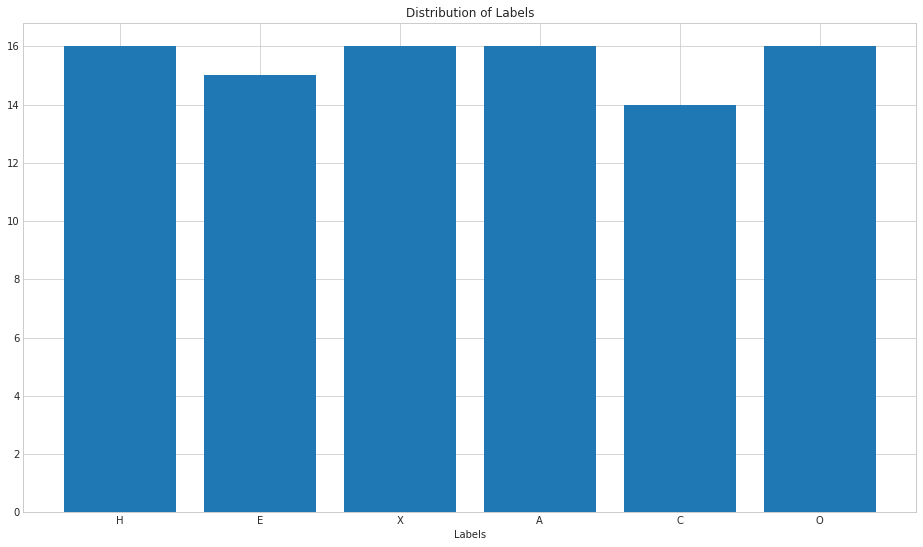

In [3]:
fig, ax = plt.subplots(figsize=(16,9))
ax.bar(['H','E','X','A','C','O'],[ sum(gt['lh']), sum(gt['le']), sum(gt['lx']), sum(gt['la']), sum(gt['lc']), sum(gt['lo'])  ])
ax.set_title("Distribution of Labels")
ax.set_xlabel("Labels")
# ax.set_ylabel("Distribution of Labels")
plt.show()

# EEG data

In [4]:
def load_data():
    path, folders, filenames = next(walk('./data'))

    filenames.remove('11-audio.csv')
    filenames.remove('11-image.csv')

    filenames.remove('36-audio.csv')
    filenames.remove('36-image.csv')

    path = './data'
    columns = {'Unnamed: 1':'Fp1',
            'Unnamed: 2':'Fp2',
            'Unnamed: 3':'F3',
            'Unnamed: 4':'F4',
            'Unnamed: 5':'F7',
            'Unnamed: 6':'F8',
            'Unnamed: 7':'P7',
            'Unnamed: 8':'P8'}

    EEG_audio, EEG_image = dict(), dict()
    from itertools import product
    categories = [1,2,3,4,5]
    blocks = [1,2]
    with tqdm(filenames) as t:
        for filename in t:
            t.set_description(f"{filename}")
            participant_id, stimuli = filename.split('-')
            stimuli = stimuli.rstrip('.csv')
            data = pandas.read_csv(f'{path}/{filename}', dtype={'Marker': str}).rename(columns=columns).drop(columns='timestamps')
            # Aviod warning on stim has negative value
            marker = np.array(data['Marker'])
            marker[marker == '-1'] = '1'
            data['Marker'] = marker

            if(stimuli == 'audio'):
                EEG_audio[int(participant_id)] = data
            elif(stimuli == 'image'):
                EEG_image[int(participant_id)] = data
            else:
                raise ValueError(f"Stimuli:{stimuli} is unexpected.")
    return EEG_audio, EEG_image


In [5]:
# clear_cache()
try:
    # Load from cache
    EEG_audio = load('EEG_audio')
    EEG_image = load('EEG_image')
    print('Load data from cache')
    if( set(EEG_audio.keys()) != set(EEG_image.keys()) ):
        extra = None
        if(len(EEG_audio.keys()) > len(EEG_image.keys())):
            extra = set(EEG_audio.keys()).difference( set(EEG_image.keys()) )
        else:
            extra = set(EEG_image.keys()).difference( set(EEG_audio.keys()) )
        raise ValueError(f"In equal keys. audio has {len(EEG_audio.keys())} and image has {len(EEG_image.keys())}. The extra key is {extra}")

except FileNotFoundError as e:
    EEG_audio, EEG_image = load_data()
    # Save to cache
    save(EEG_audio, 'EEG_audio')
    save(EEG_image, 'EEG_image')

Load data from cache


# Pre process with PSD + log + mne ICA

In [6]:
raw = dataframe_to_raw(EEG_image[33], sfreq=250)

# Preprocess
raw.notch_filter([50,100],filter_length='auto', phase='zero', verbose=False) # Line power
raw.filter(1., None, verbose=False) # Slow drift

events = mne.find_events(raw, stim_channel='Marker', initial_event=True, verbose=False, uint_cast=False)
events = np.delete(events,np.argwhere(events[:,2] == 1), axis=0) # break
# Check data
if(events.shape[0] != 50):
    raise ValueError(f"Event missing: {events[:,2]}. len(events.shape[0])={events.shape[0]}")
epochs = mne.Epochs(raw, events, tmin=2.0, tmax=4.0, baseline=(2.0,4.0), verbose=False)
if(epochs.get_data().shape[0] != 50):
    raise ValueError(f"There might be a bad data. epochs.get_data().shape = {epochs.get_data().shape}")

# for evoked in epochs.iter_evoked():
#     reduc = ica.apply(evoked, verbose=False)
#     power,freq = mne.time_frequency.psd_array_welch(reduc.data[:6],sfreq=250,n_fft=128, verbose=False)
#     break

In [7]:
import warnings
import sys, os
warnings.filterwarnings("ignore")
times = np.arange(2.0, 4.0, .5)
for evoked in epochs.iter_evoked():
    sys.stdout = open(os.devnull, 'w')
    csd_evoked = mne.preprocessing.compute_current_source_density(evoked)
    sys.stdout = sys.__stdout__
    # evoked.plot_topomap(times)
    # csd_evoked.plot_topomap(times)
    break

# raw.plot_topomap(times, ch_type='eeg', time_unit='s')
# # raw.plot_projs_topomap(0.5)
# csd_raw.plot_psd_topo()

In [8]:
mne.time_frequency.psd_array_welch(csd_evoked.data,sfreq=250,n_fft=128, verbose=False)

(array([[1.24309342e-07, 8.26078793e-07, 3.39110066e-07, 5.35063178e-08,
         1.17952311e-07, 2.46217459e-07, 3.00177584e-07, 5.04849943e-07,
         3.90926823e-07, 5.34668257e-07, 8.67768626e-07, 2.01021700e-06,
         2.11110676e-06, 8.91081953e-07, 7.10363486e-07, 1.07566892e-06,
         3.55143938e-07, 3.61076220e-07, 1.61156629e-06, 1.40996839e-06,
         6.37870696e-07, 2.58778948e-07, 1.43733555e-07, 3.03685123e-07,
         6.95751250e-07, 5.77883375e-07, 4.07471484e-07, 1.71110939e-07,
         2.65331155e-07, 2.03428206e-07, 4.22579368e-08, 2.05655356e-07,
         3.30099080e-07, 2.38476032e-07, 9.95563073e-08, 4.08693784e-07,
         2.78008581e-07, 1.84972501e-07, 1.09893685e-07, 7.87986314e-08,
         1.63169078e-07, 1.10414814e-07, 7.51406765e-08, 8.44445763e-08,
         1.78613906e-07, 1.25492447e-07, 1.39228826e-07, 1.44067752e-07,
         7.02319969e-08, 1.10004640e-07, 6.98142989e-08, 4.63530552e-08,
         8.20529899e-08, 5.25639509e-08, 9.17240726

In [9]:
# # Extract features
# events = np.array([int(event / 100) for event in epochs.events[:,2]])
# Y = None
# X = None
# csp = mne.decoding.CSP(n_components=8, transform_into='csp_space', norm_trace=True)
# data = csp.fit_transform(epochs.get_data()[:,:8,:], events)
# print(data.shape)
# for index, evoked in enumerate(epochs.iter_evoked()):
#     # event = int(evoked.comment[0])
#     # events.append(event)
#     power,freq = mne.time_frequency.psd_array_welch(data[index],sfreq=250,n_fft=128, verbose=False)
#     row = power
#     row = np.expand_dims(row, axis=0)
#     row = 10 * np.log10(row)
#     if(type(X) == type(None)): X = row
#     else: X = np.concatenate( [X, row ], axis=0 )

#     label = gt.loc[33][['lh','le','lx','la','lc','lo']].to_numpy()
#     label = np.expand_dims(label, axis=0)
#     if(type(Y) == type(None)): Y = label
#     else: Y = np.concatenate( [Y, label ], axis=0 )
# print(events.shape, X.shape, Y.shape)

In [10]:
# data = X.copy().reshape(50,-1)
# # data
# print(data.shape)
# data_norm = normalize(data.copy(), axis=0)
# mnb = GaussianNB()
# mnb.fit(data_norm, events)
# acc = sum(mnb.predict(data_norm) == events) / len(events)
# scores = cross_val_score(mnb, data_norm, events)
# print(acc, scores)

In [11]:
# proj_data.shape

In [12]:
band_names = np.array(['Delta', 'Theta', 'Alpha', 'Beta', 'Gamma'])
filter_list = [[0,4],[4,8],[8,13],[13,30],[30,125]]
def build_data(p_num, EEG,ids):
    import warnings
    import sys, os
    warnings.filterwarnings("ignore")
    X = None
    Y = None
    t_start, t_stop = (2.0,4.0)
    with tqdm(ids) as t:
        for index, id in enumerate(t):
            t.set_description(f"{id}")
            print(f"p_no={p_num}|index={index}|id={id}")
            raw = dataframe_to_raw(EEG[id], sfreq=250)
            
            # Preprocess
            raw.notch_filter([50,100],filter_length='auto', phase='zero', verbose=False) # Line power
            raw.filter(1., None, verbose=False) # Slow drift
            # ica = mne.preprocessing.ICA(n_components=8, max_iter='auto')
            # ica.fit(raw, verbose=False)
            # raw = ica.apply(raw, verbose=False)

            events = mne.find_events(raw, stim_channel='Marker', initial_event=True, verbose=False, uint_cast=False)
            events = np.delete(events,np.argwhere(events[:,2] == 1), axis=0) # break
            # Check data
            if(events.shape[0] != 50):
                raise ValueError(f"Event missing: {events[:,2]}. len(events.shape[0])={events.shape[0]}")
            epochs = mne.Epochs(raw, events, tmin=t_start, tmax=t_stop, baseline=(t_start,t_stop), verbose=False)
            if(epochs.get_data().shape[0] != 50):
                raise ValueError(f"There might be a bad data. epochs.get_data().shape = {epochs.get_data().shape}")

            # Extract features
            # events = np.array([int(event / 100) for event in epochs.events[:,2]])
            # csp = mne.decoding.CSP(n_components=3, transform_into='csp_space', norm_trace=True)
            # data = csp.fit_transform(epochs.get_data()[:,:8,:], events)
            for index_inner, evoked in enumerate(epochs.iter_evoked()):
                sys.stdout = open(os.devnull, 'w')
                evoked = mne.preprocessing.compute_current_source_density(evoked)
                sys.stdout = sys.__stdout__
                power,freq = mne.time_frequency.psd_array_welch(evoked.data,sfreq=250,n_fft=128, verbose=False)
                row = power
                row = np.expand_dims(row, axis=0)
                # row = 10 * np.log10(row)
                if(type(X) == type(None)): X = row
                else: X = np.concatenate( [X, row ], axis=0 )

                label = gt.loc[id][['lh','le','lx','la','lc','lo']].to_numpy()
                label = np.expand_dims(label, axis=0)
                if(type(Y) == type(None)): Y = label
                else: Y = np.concatenate( [Y, label ], axis=0 )

    print(f"{p_num} done| {ids}")
    return np.array(X),np.array(Y),freq

def get_accuracy(X,y):
    result = []
    traits = ["h","e","x","a","c","o"]
    for index,label in enumerate(traits):
        y = Y[:,index]
        X_copy = X.copy()
        X_copy = normalize(X_copy,axis=0)
        mnb = GaussianNB()
        mnb.fit(X_copy, y)
        acc = sum(mnb.predict(X_copy) == y) / len(y)
        scores = cross_val_score(mnb, X_copy, y)
        result.append([acc,scores.mean(),scores.std()])
        print(label,"| Accuracy: %0.2f Scores: %0.2f (+/- %0.2f)" % (acc,scores.mean(), scores.std() * 2))
    return result

In [13]:
try:
    # [33,2,10,12,16]
    t_out = 300
    pool = Pool()
    ids = np.array(list(EEG_image.keys()))
    p1 = pool.apply_async(build_data, [1,EEG_image,ids[0::6]])
    p2 = pool.apply_async(build_data, [2,EEG_image,ids[1::6]])
    p3 = pool.apply_async(build_data, [3,EEG_image,ids[2::6]])
    p4 = pool.apply_async(build_data, [4,EEG_image,ids[3::6]])
    p5 = pool.apply_async(build_data, [5,EEG_image,ids[4::6]])
    p6 = pool.apply_async(build_data, [6,EEG_image,ids[5::6]])
    ans1 = p1.get(timeout=t_out)
    ans2 = p2.get(timeout=t_out)
    ans3 = p3.get(timeout=t_out)
    ans4 = p4.get(timeout=t_out)
    ans5 = p5.get(timeout=t_out)
    ans6 = p6.get(timeout=t_out)
    X = np.concatenate([ans1[0] , ans2[0], ans3[0], ans4[0] ,ans5[0], ans6[0]])
    Y = np.concatenate([ans1[1] , ans2[1], ans3[1], ans4[1] ,ans5[1], ans6[1]])
    freq = ans1[2]
    print(X.shape, Y.shape)
finally:
    print("========= close ========")
    pool.close() 
    pool.terminate()

p_no=1|index=0|id=10


p_no=2|index=0|id=12


p_no=3|index=0|id=13


p_no=4|index=0|id=14


p_no=5|index=0|id=15


p_no=6|index=0|id=16


p_no=1|index=1|id=17


p_no=3|index=1|id=2


p_no=2|index=1|id=18


p_no=4|index=1|id=20


p_no=5|index=1|id=21


p_no=6|index=1|id=22


p_no=3|index=2|id=26


p_no=1|index=2|id=23


p_no=2|index=2|id=25


p_no=5|index=2|id=28


p_no=4|index=2|id=27


p_no=6|index=2|id=29


p_no=1|index=3|id=3


p_no=3|index=3|id=31


p_no=2|index=3|id=30


p_no=5|index=3|id=33
p_no=4|index=3|id=32


p_no=6|index=3|id=34


p_no=1|index=4|id=35


p_no=3|index=4|id=6


p_no=2|index=4|id=5


p_no=4|index=4|id=7


p_no=6|index=4|id=9


p_no=5|index=4|id=8


1 done| [10 17 23  3 35]


3 done| [13  2 26 31  6]


2 done| [12 18 25 30  5]


4 done| [14 20 27 32  7]


5 done| [15 21 28 33  8]


In [14]:
X,Y = shuffle(X,Y)
bands = []
for filt in filter_list:
    pt = np.argwhere((freq >= filt[0]) & (freq <= filt[1])).reshape(-1)
    bands.append(pt)
bands = np.array(bands)

result_image = []
best_image = 0
best_image_idx = -1
best_image_comb = None
for r in [1,2,3,4,5]:
    print("="*20,f"Number {r}","="*20)
    for comb in combinations([0,1,2,3,4],r):
        print(" ",band_names[list(comb)])
        selected_x = None
        # print(bands[ list(comb) ])
        for pt in bands[ list(comb) ]:
            # print(pt)
            if(type(selected_x) == type(None)): selected_x = X[:,:,pt].mean(axis=2)
            else:
                selected_x = np.concatenate([selected_x, X[:,:,pt].mean(axis=2)], axis=1)
        # print(selected_x.shape)
        # pts = np.concatenate( bands[ list(comb) ] )
        result = np.array(get_accuracy(selected_x,Y))
        print(" Averag accuracy:", result[:,0].mean(), "Average Score:", result[:,1].mean(), "Average Variance:", result[:,2].mean())
        result_image.append(result)
        if(result[:,1].mean() > best_image):
            best_image = result[:,1].mean()
            best_image_idx = len(result_image)-1
            best_image_comb = band_names[ list(comb) ]

print(f"Best Score is {best_image} at index {best_image_idx} with combination {best_image_comb}")

6 done| [16 22 29 34  9]
(1500, 9, 65) (1500, 6)
========= close ========
==================== Number 1 ====================
  ['Delta']


h | Accuracy: 0.50 Scores: 0.50 (+/- 0.01)
e | Accuracy: 0.61 Scores: 0.61 (+/- 0.02)
x | Accuracy: 0.55 Scores: 0.55 (+/- 0.02)
a | Accuracy: 0.52 Scores: 0.52 (+/- 0.01)
c | Accuracy: 0.59 Scores: 0.59 (+/- 0.02)
o | Accuracy: 0.51 Scores: 0.51 (+/- 0.02)
 Averag accuracy: 0.5458888888888889 Average Score: 0.5464444444444444 Average Variance: 0.008051767433066884
  ['Theta']
h | Accuracy: 0.51 Scores: 0.51 (+/- 0.02)
e | Accuracy: 0.61 Scores: 0.60 (+/- 0.02)
x | Accuracy: 0.55 Scores: 0.55 (+/- 0.01)
a | Accuracy: 0.52 Scores: 0.52 (+/- 0.01)
c | Accuracy: 0.60 Scores: 0.60 (+/- 0.01)
o | Accuracy: 0.51 Scores: 0.51 (+/- 0.02)
 Averag accuracy: 0.5487777777777777 Average Score: 0.5485555555555556 Average Variance: 0.007554989940079912
  ['Alpha']
h | Accuracy: 0.52 Scores: 0.51 (+/- 0.02)
e | Accuracy: 0.61 Scores: 0.61 (+/- 0.01)
x | Accuracy: 0.57 Scores: 0.57 (+/- 0.01)
a | Accuracy: 0.53 Scores: 0.53 (+/- 0.02)
c | Accuracy: 0.60 Scores: 0.61 (+/- 0.03)


o | Accuracy: 0.50 Scores: 0.50 (+/- 0.02)
 Averag accuracy: 0.5543333333333333 Average Score: 0.5547777777777777 Average Variance: 0.009058569172302895
  ['Beta']
h | Accuracy: 0.54 Scores: 0.53 (+/- 0.02)
e | Accuracy: 0.61 Scores: 0.60 (+/- 0.05)
x | Accuracy: 0.54 Scores: 0.53 (+/- 0.03)
a | Accuracy: 0.56 Scores: 0.57 (+/- 0.02)
c | Accuracy: 0.65 Scores: 0.66 (+/- 0.06)
o | Accuracy: 0.50 Scores: 0.49 (+/- 0.02)
 Averag accuracy: 0.5653333333333334 Average Score: 0.5634444444444445 Average Variance: 0.016148162706692504
  ['Gamma']
h | Accuracy: 0.51 Scores: 0.52 (+/- 0.02)
e | Accuracy: 0.61 Scores: 0.60 (+/- 0.01)
x | Accuracy: 0.54 Scores: 0.54 (+/- 0.01)
a | Accuracy: 0.52 Scores: 0.52 (+/- 0.02)
c | Accuracy: 0.60 Scores: 0.61 (+/- 0.05)
o | Accuracy: 0.51 Scores: 0.51 (+/- 0.01)
 Averag accuracy: 0.5475555555555556 Average Score: 0.5486666666666666 Average Variance: 0.008950171802644612
==================== Number 2 ====================
  ['Delta' 'Theta']
h | Accuracy: 0.5

a | Accuracy: 0.52 Scores: 0.52 (+/- 0.01)
c | Accuracy: 0.60 Scores: 0.60 (+/- 0.01)
o | Accuracy: 0.51 Scores: 0.51 (+/- 0.02)
 Averag accuracy: 0.5491111111111111 Average Score: 0.5484444444444445 Average Variance: 0.008440025264776269
  ['Delta' 'Alpha']
h | Accuracy: 0.51 Scores: 0.51 (+/- 0.01)
e | Accuracy: 0.61 Scores: 0.61 (+/- 0.02)
x | Accuracy: 0.56 Scores: 0.56 (+/- 0.02)
a | Accuracy: 0.53 Scores: 0.53 (+/- 0.01)
c | Accuracy: 0.60 Scores: 0.60 (+/- 0.02)
o | Accuracy: 0.51 Scores: 0.51 (+/- 0.02)
 Averag accuracy: 0.5521111111111111 Average Score: 0.5526666666666666 Average Variance: 0.008636315074300165
  ['Delta' 'Beta']
h | Accuracy: 0.53 Scores: 0.53 (+/- 0.01)
e | Accuracy: 0.61 Scores: 0.61 (+/- 0.02)
x | Accuracy: 0.55 Scores: 0.55 (+/- 0.01)
a | Accuracy: 0.56 Scores: 0.56 (+/- 0.02)
c | Accuracy: 0.63 Scores: 0.64 (+/- 0.04)
o | Accuracy: 0.51 Scores: 0.51 (+/- 0.02)
 Averag accuracy: 0.5634444444444445 Average Score: 0.5642222222222223 Average Variance: 0.01041

x | Accuracy: 0.55 Scores: 0.55 (+/- 0.01)
a | Accuracy: 0.53 Scores: 0.53 (+/- 0.02)
c | Accuracy: 0.61 Scores: 0.61 (+/- 0.04)
o | Accuracy: 0.51 Scores: 0.51 (+/- 0.02)
 Averag accuracy: 0.5529999999999999 Average Score: 0.5538888888888889 Average Variance: 0.011110359524750148
  ['Theta' 'Alpha']
h | Accuracy: 0.51 Scores: 0.51 (+/- 0.01)
e | Accuracy: 0.61 Scores: 0.60 (+/- 0.02)
x | Accuracy: 0.56 Scores: 0.57 (+/- 0.01)
a | Accuracy: 0.52 Scores: 0.52 (+/- 0.01)
c | Accuracy: 0.60 Scores: 0.60 (+/- 0.02)
o | Accuracy: 0.51 Scores: 0.50 (+/- 0.02)
 Averag accuracy: 0.5517777777777777 Average Score: 0.5514444444444445 Average Variance: 0.007633064354793451
  ['Theta' 'Beta']
h | Accuracy: 0.53 Scores: 0.53 (+/- 0.03)
e | Accuracy: 0.61 Scores: 0.61 (+/- 0.02)
x | Accuracy: 0.56 Scores: 0.56 (+/- 0.02)
a | Accuracy: 0.55 Scores: 0.55 (+/- 0.02)


c | Accuracy: 0.64 Scores: 0.65 (+/- 0.04)
o | Accuracy: 0.50 Scores: 0.50 (+/- 0.02)
 Averag accuracy: 0.5653333333333334 Average Score: 0.5656666666666667 Average Variance: 0.011840563248524347
  ['Theta' 'Gamma']
h | Accuracy: 0.52 Scores: 0.51 (+/- 0.02)
e | Accuracy: 0.61 Scores: 0.61 (+/- 0.02)
x | Accuracy: 0.56 Scores: 0.56 (+/- 0.02)
a | Accuracy: 0.52 Scores: 0.52 (+/- 0.02)
c | Accuracy: 0.61 Scores: 0.62 (+/- 0.04)
o | Accuracy: 0.51 Scores: 0.51 (+/- 0.02)
 Averag accuracy: 0.5553333333333333 Average Score: 0.5556666666666666 Average Variance: 0.010494717401534825
  ['Alpha' 'Beta']
h | Accuracy: 0.53 Scores: 0.53 (+/- 0.03)
e | Accuracy: 0.61 Scores: 0.61 (+/- 0.01)
x | Accuracy: 0.56 Scores: 0.57 (+/- 0.02)
a | Accuracy: 0.55 Scores: 0.55 (+/- 0.03)
c | Accuracy: 0.64 Scores: 0.65 (+/- 0.05)
o | Accuracy: 0.50 Scores: 0.50 (+/- 0.02)
 Averag accuracy: 0.5666666666666668 Average Score: 0.5682222222222222 Average Variance: 0.012962780862933265
  ['Alpha' 'Gamma']
h | Accur

e | Accuracy: 0.61 Scores: 0.61 (+/- 0.01)
x | Accuracy: 0.57 Scores: 0.57 (+/- 0.02)
a | Accuracy: 0.53 Scores: 0.53 (+/- 0.02)
c | Accuracy: 0.61 Scores: 0.62 (+/- 0.05)
o | Accuracy: 0.51 Scores: 0.51 (+/- 0.02)
 Averag accuracy: 0.559 Average Score: 0.5601111111111111 Average Variance: 0.010980792780433152
  ['Beta' 'Gamma']
h | Accuracy: 0.54 Scores: 0.54 (+/- 0.03)
e | Accuracy: 0.61 Scores: 0.61 (+/- 0.01)
x | Accuracy: 0.54 Scores: 0.54 (+/- 0.01)
a | Accuracy: 0.54 Scores: 0.54 (+/- 0.02)
c | Accuracy: 0.63 Scores: 0.64 (+/- 0.04)
o | Accuracy: 0.51 Scores: 0.51 (+/- 0.01)
 Averag accuracy: 0.5611111111111111 Average Score: 0.5624444444444444 Average Variance: 0.010727642664959493
==================== Number 3 ====================
  ['Delta' 'Theta' 'Alpha']
h | Accuracy: 0.51 Scores: 0.51 (+/- 0.01)
e | Accuracy: 0.61 Scores: 0.61 (+/- 0.02)
x | Accuracy: 0.56 Scores: 0.56 (+/- 0.01)
a | Accuracy: 0.52 Scores: 0.52 (+/- 0.01)
c | Accuracy: 0.60 Scores: 0.60 (+/- 0.01)


o | Accuracy: 0.51 Scores: 0.51 (+/- 0.02)
 Averag accuracy: 0.5516666666666666 Average Score: 0.5511111111111111 Average Variance: 0.007248143954694461
  ['Delta' 'Theta' 'Beta']
h | Accuracy: 0.52 Scores: 0.52 (+/- 0.03)
e | Accuracy: 0.61 Scores: 0.61 (+/- 0.02)
x | Accuracy: 0.56 Scores: 0.56 (+/- 0.02)
a | Accuracy: 0.55 Scores: 0.55 (+/- 0.03)
c | Accuracy: 0.63 Scores: 0.63 (+/- 0.03)
o | Accuracy: 0.51 Scores: 0.51 (+/- 0.02)
 Averag accuracy: 0.5619999999999999 Average Score: 0.5615555555555555 Average Variance: 0.011714451999253098
  ['Delta' 'Theta' 'Gamma']
h | Accuracy: 0.51 Scores: 0.51 (+/- 0.02)
e | Accuracy: 0.61 Scores: 0.61 (+/- 0.02)
x | Accuracy: 0.56 Scores: 0.56 (+/- 0.02)
a | Accuracy: 0.52 Scores: 0.52 (+/- 0.01)
c | Accuracy: 0.61 Scores: 0.62 (+/- 0.04)
o | Accuracy: 0.51 Scores: 0.51 (+/- 0.02)
 Averag accuracy: 0.5535555555555556 Average Score: 0.5552222222222222 Average Variance: 0.010823998016008257
  ['Delta' 'Alpha' 'Beta']
h | Accuracy: 0.52 Scores: 0.

a | Accuracy: 0.55 Scores: 0.55 (+/- 0.02)
c | Accuracy: 0.63 Scores: 0.64 (+/- 0.04)
o | Accuracy: 0.51 Scores: 0.51 (+/- 0.02)
 Averag accuracy: 0.5630000000000001 Average Score: 0.5644444444444444 Average Variance: 0.012091536656368128
  ['Delta' 'Alpha' 'Gamma']
h | Accuracy: 0.52 Scores: 0.52 (+/- 0.01)
e | Accuracy: 0.61 Scores: 0.61 (+/- 0.02)
x | Accuracy: 0.56 Scores: 0.56 (+/- 0.02)
a | Accuracy: 0.53 Scores: 0.53 (+/- 0.01)
c | Accuracy: 0.61 Scores: 0.62 (+/- 0.05)
o | Accuracy: 0.52 Scores: 0.51 (+/- 0.01)
 Averag accuracy: 0.5576666666666666 Average Score: 0.5594444444444444 Average Variance: 0.010394060364597014
  ['Delta' 'Beta' 'Gamma']
h | Accuracy: 0.53 Scores: 0.53 (+/- 0.03)
e | Accuracy: 0.61 Scores: 0.61 (+/- 0.02)
x | Accuracy: 0.55 Scores: 0.55 (+/- 0.01)
a | Accuracy: 0.55 Scores: 0.55 (+/- 0.02)
c | Accuracy: 0.63 Scores: 0.63 (+/- 0.03)


o | Accuracy: 0.52 Scores: 0.52 (+/- 0.02)
 Averag accuracy: 0.5642222222222223 Average Score: 0.5653333333333334 Average Variance: 0.01081942916682596
  ['Theta' 'Alpha' 'Beta']
h | Accuracy: 0.53 Scores: 0.53 (+/- 0.03)
e | Accuracy: 0.61 Scores: 0.61 (+/- 0.02)
x | Accuracy: 0.56 Scores: 0.56 (+/- 0.01)
a | Accuracy: 0.54 Scores: 0.54 (+/- 0.02)
c | Accuracy: 0.63 Scores: 0.64 (+/- 0.04)
o | Accuracy: 0.51 Scores: 0.51 (+/- 0.02)
 Averag accuracy: 0.5635555555555555 Average Score: 0.5637777777777777 Average Variance: 0.01236823856455442
  ['Theta' 'Alpha' 'Gamma']
h | Accuracy: 0.52 Scores: 0.52 (+/- 0.01)
e | Accuracy: 0.61 Scores: 0.61 (+/- 0.02)
x | Accuracy: 0.56 Scores: 0.56 (+/- 0.01)
a | Accuracy: 0.53 Scores: 0.53 (+/- 0.01)
c | Accuracy: 0.61 Scores: 0.62 (+/- 0.04)
o | Accuracy: 0.51 Scores: 0.51 (+/- 0.02)
 Averag accuracy: 0.5569999999999999 Average Score: 0.5586666666666666 Average Variance: 0.009027314537115472
  ['Theta' 'Beta' 'Gamma']
h | Accuracy: 0.53 Scores: 0.53

a | Accuracy: 0.54 Scores: 0.54 (+/- 0.02)
c | Accuracy: 0.64 Scores: 0.64 (+/- 0.03)
o | Accuracy: 0.51 Scores: 0.51 (+/- 0.02)
 Averag accuracy: 0.5655555555555556 Average Score: 0.5664444444444445 Average Variance: 0.011161389263919358
  ['Alpha' 'Beta' 'Gamma']
h | Accuracy: 0.54 Scores: 0.54 (+/- 0.03)
e | Accuracy: 0.61 Scores: 0.61 (+/- 0.01)
x | Accuracy: 0.56 Scores: 0.56 (+/- 0.01)
a | Accuracy: 0.54 Scores: 0.54 (+/- 0.02)
c | Accuracy: 0.63 Scores: 0.63 (+/- 0.04)
o | Accuracy: 0.51 Scores: 0.51 (+/- 0.02)
 Averag accuracy: 0.5653333333333334 Average Score: 0.5675555555555555 Average Variance: 0.011214521759258293
==================== Number 4 ====================
  ['Delta' 'Theta' 'Alpha' 'Beta']
h | Accuracy: 0.52 Scores: 0.52 (+/- 0.03)
e | Accuracy: 0.61 Scores: 0.61 (+/- 0.02)
x | Accuracy: 0.56 Scores: 0.56 (+/- 0.02)
a | Accuracy: 0.54 Scores: 0.54 (+/- 0.02)
c | Accuracy: 0.63 Scores: 0.63 (+/- 0.04)
o | Accuracy: 0.51 Scores: 0.51 (+/- 0.02)
 Averag accuracy: 0.56

h | Accuracy: 0.52 Scores: 0.52 (+/- 0.01)
e | Accuracy: 0.61 Scores: 0.61 (+/- 0.02)
x | Accuracy: 0.56 Scores: 0.56 (+/- 0.02)
a | Accuracy: 0.53 Scores: 0.53 (+/- 0.01)
c | Accuracy: 0.61 Scores: 0.61 (+/- 0.03)
o | Accuracy: 0.51 Scores: 0.51 (+/- 0.01)
 Averag accuracy: 0.5564444444444444 Average Score: 0.5561111111111111 Average Variance: 0.00899292271389409
  ['Delta' 'Theta' 'Beta' 'Gamma']
h | Accuracy: 0.53 Scores: 0.52 (+/- 0.03)
e | Accuracy: 0.61 Scores: 0.61 (+/- 0.02)
x | Accuracy: 0.56 Scores: 0.56 (+/- 0.02)
a | Accuracy: 0.54 Scores: 0.54 (+/- 0.02)
c | Accuracy: 0.63 Scores: 0.64 (+/- 0.03)
o | Accuracy: 0.51 Scores: 0.51 (+/- 0.02)
 Averag accuracy: 0.564 Average Score: 0.5640000000000001 Average Variance: 0.011235108608788597
  ['Delta' 'Alpha' 'Beta' 'Gamma']
h | Accuracy: 0.53 Scores: 0.53 (+/- 0.02)
e | Accuracy: 0.61 Scores: 0.61 (+/- 0.02)


x | Accuracy: 0.56 Scores: 0.56 (+/- 0.01)
a | Accuracy: 0.54 Scores: 0.55 (+/- 0.02)
c | Accuracy: 0.63 Scores: 0.63 (+/- 0.04)
o | Accuracy: 0.51 Scores: 0.52 (+/- 0.01)
 Averag accuracy: 0.5652222222222222 Average Score: 0.5669999999999998 Average Variance: 0.010578662938562916
  ['Theta' 'Alpha' 'Beta' 'Gamma']
h | Accuracy: 0.53 Scores: 0.53 (+/- 0.02)
e | Accuracy: 0.61 Scores: 0.61 (+/- 0.02)
x | Accuracy: 0.56 Scores: 0.56 (+/- 0.02)
a | Accuracy: 0.54 Scores: 0.55 (+/- 0.02)
c | Accuracy: 0.63 Scores: 0.63 (+/- 0.03)
o | Accuracy: 0.51 Scores: 0.51 (+/- 0.01)
 Averag accuracy: 0.5648888888888889 Average Score: 0.5660000000000001 Average Variance: 0.010354707813235444
==================== Number 5 ====================
  ['Delta' 'Theta' 'Alpha' 'Beta' 'Gamma']
h | Accuracy: 0.52 Scores: 0.53 (+/- 0.02)
e | Accuracy: 0.61 Scores: 0.61 (+/- 0.02)
x | Accuracy: 0.56 Scores: 0.56 (+/- 0.02)
a | Accuracy: 0.54 Scores: 0.54 (+/- 0.02)


In [15]:
try:
    # [33,2,10,12,16]
    t_out = 300
    pool = Pool()
    ids = np.array(list(EEG_audio.keys()))
    p1 = pool.apply_async(build_data, [1,EEG_audio,ids[0::6]])
    p2 = pool.apply_async(build_data, [2,EEG_audio,ids[1::6]])
    p3 = pool.apply_async(build_data, [3,EEG_audio,ids[2::6]])
    p4 = pool.apply_async(build_data, [4,EEG_audio,ids[3::6]])
    p5 = pool.apply_async(build_data, [5,EEG_audio,ids[4::6]])
    p6 = pool.apply_async(build_data, [6,EEG_audio,ids[5::6]])
    ans1 = p1.get(timeout=t_out)
    ans2 = p2.get(timeout=t_out)
    ans3 = p3.get(timeout=t_out)
    ans4 = p4.get(timeout=t_out)
    ans5 = p5.get(timeout=t_out)
    ans6 = p6.get(timeout=t_out)
    X = np.concatenate([ans1[0] , ans2[0], ans3[0], ans4[0] ,ans5[0], ans6[0]])
    Y = np.concatenate([ans1[1] , ans2[1], ans3[1], ans4[1] ,ans5[1], ans6[1]])
    freq = ans1[2]
    print(X.shape, Y.shape)
finally:
    print("========= close ========")
    pool.close() 
    pool.terminate()

c | Accuracy: 0.63 Scores: 0.63 (+/- 0.04)
o | Accuracy: 0.51 Scores: 0.51 (+/- 0.01)
 Averag accuracy: 0.563111111111111 Average Score: 0.5635555555555556 Average Variance: 0.011140640852069473
Best Score is 0.5682222222222222 at index 12 with combination ['Alpha' 'Beta']


p_no=1|index=0|id=10


p_no=2|index=0|id=12


p_no=3|index=0|id=13


p_no=4|index=0|id=14


p_no=5|index=0|id=15


p_no=6|index=0|id=16


p_no=1|index=1|id=17


p_no=3|index=1|id=2


p_no=2|index=1|id=18


p_no=4|index=1|id=20


p_no=6|index=1|id=22


p_no=5|index=1|id=21


p_no=1|index=2|id=23


p_no=6|index=2|id=29


p_no=2|index=2|id=25


p_no=3|index=2|id=26


p_no=4|index=2|id=27


p_no=5|index=2|id=28


p_no=1|index=3|id=3


p_no=3|index=3|id=31


p_no=6|index=3|id=34


p_no=2|index=3|id=30


p_no=5|index=3|id=33


p_no=4|index=3|id=32


p_no=1|index=4|id=35


p_no=6|index=4|id=9


p_no=3|index=4|id=6


p_no=2|index=4|id=5


p_no=4|index=4|id=7


p_no=5|index=4|id=8


1 done| [10 17 23  3 35]


6 done| [16 22 29 34  9]


3 done| [13  2 26 31  6]


5 done| [15 21 28 33  8]


4 done| [14 20 27 32  7]


In [16]:
X,Y = shuffle(X,Y)
bands = []
for filt in filter_list:
    pt = np.argwhere((freq >= filt[0]) & (freq <= filt[1])).reshape(-1)
    bands.append(pt)
bands = np.array(bands)

result_audio = []
best_audio = 0
best_audio_idx = -1
best_audio_comb = None
for r in [1,2,3,4,5]:
    print("="*20,f"Number {r}","="*20)
    for comb in combinations([0,1,2,3,4],r):
        print(" ",band_names[list(comb)])
        selected_x = None
        # print(bands[ list(comb) ])
        for pt in bands[ list(comb) ]:
            # print(pt)
            if(type(selected_x) == type(None)): selected_x = X[:,:,pt].mean(axis=2)
            else:
                selected_x = np.concatenate([selected_x, X[:,:,pt].mean(axis=2)], axis=1)
        # print(selected_x.shape)
        # pts = np.concatenate( bands[ list(comb) ] )
        result = np.array(get_accuracy(selected_x,Y))
        print(" Averag accuracy:", result[:,0].mean(), "Average Score:", result[:,1].mean(), "Average Variance:", result[:,2].mean())
        result_audio.append(result)
        if(result[:,1].mean() > best_audio):
            best_audio = result[:,1].mean()
            best_audio_idx = len(result_audio)-1
            best_audio_comb = band_names[ list(comb) ]

print(f"Best Score is {best_audio} at index {best_audio_idx} with combination {best_audio_comb}")

2 done| [12 18 25 30  5]
(1500, 9, 65) (1500, 6)
========= close ========
==================== Number 1 ====================
  ['Delta']
h | Accuracy: 0.50 Scores: 0.50 (+/- 0.01)


e | Accuracy: 0.60 Scores: 0.61 (+/- 0.02)
x | Accuracy: 0.56 Scores: 0.56 (+/- 0.03)
a | Accuracy: 0.51 Scores: 0.51 (+/- 0.02)
c | Accuracy: 0.59 Scores: 0.59 (+/- 0.03)
o | Accuracy: 0.51 Scores: 0.52 (+/- 0.01)
 Averag accuracy: 0.5465555555555556 Average Score: 0.5465555555555556 Average Variance: 0.00997693255132547
  ['Theta']
h | Accuracy: 0.50 Scores: 0.51 (+/- 0.01)
e | Accuracy: 0.60 Scores: 0.60 (+/- 0.02)
x | Accuracy: 0.57 Scores: 0.57 (+/- 0.04)
a | Accuracy: 0.50 Scores: 0.50 (+/- 0.01)
c | Accuracy: 0.59 Scores: 0.59 (+/- 0.03)
o | Accuracy: 0.51 Scores: 0.52 (+/- 0.02)
 Averag accuracy: 0.544 Average Score: 0.5452222222222222 Average Variance: 0.012002610583359101
  ['Alpha']
h | Accuracy: 0.52 Scores: 0.52 (+/- 0.03)
e | Accuracy: 0.59 Scores: 0.59 (+/- 0.02)
x | Accuracy: 0.59 Scores: 0.60 (+/- 0.04)
a | Accuracy: 0.52 Scores: 0.52 (+/- 0.04)
c | Accuracy: 0.56 Scores: 0.55 (+/- 0.03)
o | Accuracy: 0.50 Scores: 0.55 (+/- 0.14)
 Averag accuracy: 0.546 Average Score: 

h | Accuracy: 0.56 Scores: 0.56 (+/- 0.03)
e | Accuracy: 0.63 Scores: 0.64 (+/- 0.03)
x | Accuracy: 0.53 Scores: 0.53 (+/- 0.03)
a | Accuracy: 0.54 Scores: 0.54 (+/- 0.02)
c | Accuracy: 0.69 Scores: 0.69 (+/- 0.01)
o | Accuracy: 0.49 Scores: 0.48 (+/- 0.03)
 Averag accuracy: 0.572 Average Score: 0.573111111111111 Average Variance: 0.012890678459699814
  ['Gamma']
h | Accuracy: 0.56 Scores: 0.54 (+/- 0.06)
e | Accuracy: 0.40 Scores: 0.41 (+/- 0.02)
x | Accuracy: 0.53 Scores: 0.53 (+/- 0.01)
a | Accuracy: 0.51 Scores: 0.51 (+/- 0.03)
c | Accuracy: 0.67 Scores: 0.67 (+/- 0.04)
o | Accuracy: 0.45 Scores: 0.48 (+/- 0.06)
 Averag accuracy: 0.521 Average Score: 0.5236666666666666 Average Variance: 0.018627804743709234
==================== Number 2 ====================
  ['Delta' 'Theta']
h | Accuracy: 0.50 Scores: 0.50 (+/- 0.01)
e | Accuracy: 0.60 Scores: 0.60 (+/- 0.03)
x | Accuracy: 0.57 Scores: 0.57 (+/- 0.03)


a | Accuracy: 0.50 Scores: 0.50 (+/- 0.02)
c | Accuracy: 0.59 Scores: 0.59 (+/- 0.04)
o | Accuracy: 0.51 Scores: 0.51 (+/- 0.01)
 Averag accuracy: 0.5467777777777778 Average Score: 0.5461111111111112 Average Variance: 0.011702412047781462
  ['Delta' 'Alpha']
h | Accuracy: 0.52 Scores: 0.52 (+/- 0.02)
e | Accuracy: 0.60 Scores: 0.60 (+/- 0.03)
x | Accuracy: 0.58 Scores: 0.58 (+/- 0.03)
a | Accuracy: 0.51 Scores: 0.51 (+/- 0.03)
c | Accuracy: 0.59 Scores: 0.58 (+/- 0.02)
o | Accuracy: 0.51 Scores: 0.52 (+/- 0.01)
 Averag accuracy: 0.5517777777777778 Average Score: 0.5526666666666668 Average Variance: 0.011904601783626801
  ['Delta' 'Beta']
h | Accuracy: 0.54 Scores: 0.55 (+/- 0.01)
e | Accuracy: 0.60 Scores: 0.61 (+/- 0.02)
x | Accuracy: 0.56 Scores: 0.56 (+/- 0.03)
a | Accuracy: 0.54 Scores: 0.54 (+/- 0.03)
c | Accuracy: 0.66 Scores: 0.66 (+/- 0.03)
o | Accuracy: 0.51 Scores: 0.51 (+/- 0.02)
 Averag accuracy: 0.5698888888888889 Average Score: 0.571111111111111 Average Variance: 0.012145

x | Accuracy: 0.56 Scores: 0.56 (+/- 0.03)
a | Accuracy: 0.52 Scores: 0.51 (+/- 0.03)
c | Accuracy: 0.65 Scores: 0.65 (+/- 0.05)
o | Accuracy: 0.51 Scores: 0.51 (+/- 0.02)
 Averag accuracy: 0.5594444444444444 Average Score: 0.5565555555555556 Average Variance: 0.023289892657266636
  ['Theta' 'Alpha']
h | Accuracy: 0.52 Scores: 0.52 (+/- 0.02)
e | Accuracy: 0.59 Scores: 0.59 (+/- 0.03)
x | Accuracy: 0.59 Scores: 0.59 (+/- 0.05)
a | Accuracy: 0.51 Scores: 0.51 (+/- 0.02)
c | Accuracy: 0.58 Scores: 0.58 (+/- 0.03)
o | Accuracy: 0.51 Scores: 0.51 (+/- 0.03)
 Averag accuracy: 0.551 Average Score: 0.5507777777777777 Average Variance: 0.014852628405711854
  ['Theta' 'Beta']
h | Accuracy: 0.55 Scores: 0.55 (+/- 0.03)
e | Accuracy: 0.60 Scores: 0.60 (+/- 0.02)
x | Accuracy: 0.57 Scores: 0.57 (+/- 0.04)
a | Accuracy: 0.54 Scores: 0.54 (+/- 0.03)
c | Accuracy: 0.68 Scores: 0.68 (+/- 0.03)


o | Accuracy: 0.50 Scores: 0.50 (+/- 0.03)
 Averag accuracy: 0.5728888888888889 Average Score: 0.5725555555555556 Average Variance: 0.013752160619393819
  ['Theta' 'Gamma']
h | Accuracy: 0.52 Scores: 0.54 (+/- 0.05)
e | Accuracy: 0.60 Scores: 0.54 (+/- 0.15)
x | Accuracy: 0.57 Scores: 0.57 (+/- 0.03)
a | Accuracy: 0.51 Scores: 0.51 (+/- 0.03)
c | Accuracy: 0.66 Scores: 0.66 (+/- 0.04)
o | Accuracy: 0.51 Scores: 0.51 (+/- 0.02)
 Averag accuracy: 0.5615555555555556 Average Score: 0.5533333333333333 Average Variance: 0.027237149349166264
  ['Alpha' 'Beta']
h | Accuracy: 0.58 Scores: 0.58 (+/- 0.03)
e | Accuracy: 0.60 Scores: 0.60 (+/- 0.02)
x | Accuracy: 0.59 Scores: 0.59 (+/- 0.05)
a | Accuracy: 0.55 Scores: 0.55 (+/- 0.03)
c | Accuracy: 0.68 Scores: 0.68 (+/- 0.03)
o | Accuracy: 0.48 Scores: 0.49 (+/- 0.02)
 Averag accuracy: 0.5795555555555555 Average Score: 0.5805555555555555 Average Variance: 0.015107068224672908
  ['Alpha' 'Gamma']
h | Accuracy: 0.56 Scores: 0.56 (+/- 0.04)
e | Accur

a | Accuracy: 0.53 Scores: 0.53 (+/- 0.05)
c | Accuracy: 0.65 Scores: 0.66 (+/- 0.02)
o | Accuracy: 0.49 Scores: 0.49 (+/- 0.07)
 Averag accuracy: 0.5631111111111111 Average Score: 0.5551111111111111 Average Variance: 0.03248332457608639
  ['Beta' 'Gamma']
h | Accuracy: 0.56 Scores: 0.56 (+/- 0.03)
e | Accuracy: 0.43 Scores: 0.52 (+/- 0.24)
x | Accuracy: 0.53 Scores: 0.54 (+/- 0.03)
a | Accuracy: 0.54 Scores: 0.54 (+/- 0.03)
c | Accuracy: 0.69 Scores: 0.69 (+/- 0.03)
o | Accuracy: 0.48 Scores: 0.48 (+/- 0.02)
 Averag accuracy: 0.5402222222222222 Average Score: 0.5533333333333333 Average Variance: 0.030979627073077526
==================== Number 3 ====================
  ['Delta' 'Theta' 'Alpha']
h | Accuracy: 0.52 Scores: 0.52 (+/- 0.01)
e | Accuracy: 0.60 Scores: 0.60 (+/- 0.03)
x | Accuracy: 0.59 Scores: 0.59 (+/- 0.04)
a | Accuracy: 0.51 Scores: 0.51 (+/- 0.02)
c | Accuracy: 0.59 Scores: 0.59 (+/- 0.04)
o | Accuracy: 0.52 Scores: 0.51 (+/- 0.01)
 Averag accuracy: 0.5518888888888889 A

h | Accuracy: 0.54 Scores: 0.54 (+/- 0.03)
e | Accuracy: 0.60 Scores: 0.60 (+/- 0.03)
x | Accuracy: 0.57 Scores: 0.57 (+/- 0.03)
a | Accuracy: 0.52 Scores: 0.53 (+/- 0.03)
c | Accuracy: 0.65 Scores: 0.65 (+/- 0.05)
o | Accuracy: 0.51 Scores: 0.51 (+/- 0.01)
 Averag accuracy: 0.5653333333333334 Average Score: 0.5642222222222223 Average Variance: 0.015735413387325137
  ['Delta' 'Theta' 'Gamma']
h | Accuracy: 0.51 Scores: 0.52 (+/- 0.04)
e | Accuracy: 0.60 Scores: 0.60 (+/- 0.03)
x | Accuracy: 0.57 Scores: 0.57 (+/- 0.04)
a | Accuracy: 0.51 Scores: 0.51 (+/- 0.03)
c | Accuracy: 0.64 Scores: 0.65 (+/- 0.05)
o | Accuracy: 0.51 Scores: 0.51 (+/- 0.01)
 Averag accuracy: 0.5567777777777777 Average Score: 0.5597777777777778 Average Variance: 0.0170858533568949
  ['Delta' 'Alpha' 'Beta']
h | Accuracy: 0.56 Scores: 0.56 (+/- 0.03)
e | Accuracy: 0.60 Scores: 0.60 (+/- 0.03)
x | Accuracy: 0.58 Scores: 0.58 (+/- 0.03)
a | Accuracy: 0.53 Scores: 0.53 (+/- 0.04)


c | Accuracy: 0.65 Scores: 0.65 (+/- 0.04)
o | Accuracy: 0.51 Scores: 0.51 (+/- 0.02)
 Averag accuracy: 0.5731111111111112 Average Score: 0.5738888888888889 Average Variance: 0.01597081727301388
  ['Delta' 'Alpha' 'Gamma']
h | Accuracy: 0.53 Scores: 0.54 (+/- 0.04)
e | Accuracy: 0.60 Scores: 0.60 (+/- 0.04)
x | Accuracy: 0.58 Scores: 0.58 (+/- 0.03)
a | Accuracy: 0.51 Scores: 0.52 (+/- 0.03)
c | Accuracy: 0.65 Scores: 0.65 (+/- 0.04)
o | Accuracy: 0.51 Scores: 0.51 (+/- 0.01)
 Averag accuracy: 0.5634444444444444 Average Score: 0.5667777777777778 Average Variance: 0.016451285984157026
  ['Delta' 'Beta' 'Gamma']
h | Accuracy: 0.55 Scores: 0.56 (+/- 0.03)
e | Accuracy: 0.60 Scores: 0.59 (+/- 0.08)
x | Accuracy: 0.56 Scores: 0.56 (+/- 0.03)
a | Accuracy: 0.54 Scores: 0.53 (+/- 0.03)
c | Accuracy: 0.68 Scores: 0.68 (+/- 0.03)
o | Accuracy: 0.51 Scores: 0.51 (+/- 0.02)
 Averag accuracy: 0.574 Average Score: 0.5704444444444444 Average Variance: 0.018280600429138132
  ['Theta' 'Alpha' 'Beta']


e | Accuracy: 0.59 Scores: 0.60 (+/- 0.03)
x | Accuracy: 0.59 Scores: 0.59 (+/- 0.05)
a | Accuracy: 0.53 Scores: 0.54 (+/- 0.04)
c | Accuracy: 0.67 Scores: 0.67 (+/- 0.03)
o | Accuracy: 0.51 Scores: 0.50 (+/- 0.01)
 Averag accuracy: 0.5757777777777778 Average Score: 0.5760000000000001 Average Variance: 0.015121096026726033
  ['Theta' 'Alpha' 'Gamma']
h | Accuracy: 0.53 Scores: 0.55 (+/- 0.05)
e | Accuracy: 0.59 Scores: 0.59 (+/- 0.04)
x | Accuracy: 0.59 Scores: 0.59 (+/- 0.04)
a | Accuracy: 0.52 Scores: 0.52 (+/- 0.05)
c | Accuracy: 0.65 Scores: 0.65 (+/- 0.04)
o | Accuracy: 0.51 Scores: 0.51 (+/- 0.02)
 Averag accuracy: 0.5643333333333334 Average Score: 0.5673333333333334 Average Variance: 0.018851730784924366
  ['Theta' 'Beta' 'Gamma']
h | Accuracy: 0.56 Scores: 0.56 (+/- 0.04)
e | Accuracy: 0.61 Scores: 0.55 (+/- 0.13)
x | Accuracy: 0.57 Scores: 0.57 (+/- 0.04)
a | Accuracy: 0.54 Scores: 0.53 (+/- 0.03)


c | Accuracy: 0.68 Scores: 0.68 (+/- 0.03)
o | Accuracy: 0.50 Scores: 0.50 (+/- 0.04)
 Averag accuracy: 0.5753333333333334 Average Score: 0.5645555555555556 Average Variance: 0.02475888569761088
  ['Alpha' 'Beta' 'Gamma']
h | Accuracy: 0.58 Scores: 0.58 (+/- 0.03)
e | Accuracy: 0.61 Scores: 0.54 (+/- 0.16)
x | Accuracy: 0.58 Scores: 0.58 (+/- 0.04)
a | Accuracy: 0.54 Scores: 0.54 (+/- 0.04)
c | Accuracy: 0.68 Scores: 0.68 (+/- 0.02)
o | Accuracy: 0.48 Scores: 0.49 (+/- 0.02)
 Averag accuracy: 0.5795555555555555 Average Score: 0.5707777777777777 Average Variance: 0.026558896296159377
==================== Number 4 ====================
  ['Delta' 'Theta' 'Alpha' 'Beta']
h | Accuracy: 0.54 Scores: 0.54 (+/- 0.03)
e | Accuracy: 0.60 Scores: 0.60 (+/- 0.03)
x | Accuracy: 0.59 Scores: 0.59 (+/- 0.04)
a | Accuracy: 0.53 Scores: 0.53 (+/- 0.03)
c | Accuracy: 0.64 Scores: 0.64 (+/- 0.05)
o | Accuracy: 0.52 Scores: 0.51 (+/- 0.01)
 Averag accuracy: 0.5693333333333334 Average Score: 0.569222222222

e | Accuracy: 0.60 Scores: 0.60 (+/- 0.04)
x | Accuracy: 0.58 Scores: 0.59 (+/- 0.04)
a | Accuracy: 0.52 Scores: 0.51 (+/- 0.03)
c | Accuracy: 0.64 Scores: 0.64 (+/- 0.04)
o | Accuracy: 0.51 Scores: 0.51 (+/- 0.01)
 Averag accuracy: 0.5623333333333334 Average Score: 0.5641111111111111 Average Variance: 0.016938394431495182
  ['Delta' 'Theta' 'Beta' 'Gamma']
h | Accuracy: 0.54 Scores: 0.55 (+/- 0.05)
e | Accuracy: 0.60 Scores: 0.60 (+/- 0.04)
x | Accuracy: 0.57 Scores: 0.57 (+/- 0.03)
a | Accuracy: 0.52 Scores: 0.52 (+/- 0.04)
c | Accuracy: 0.67 Scores: 0.67 (+/- 0.04)
o | Accuracy: 0.51 Scores: 0.50 (+/- 0.01)
 Averag accuracy: 0.5681111111111111 Average Score: 0.5693333333333334 Average Variance: 0.017811439495268578
  ['Delta' 'Alpha' 'Beta' 'Gamma']
h | Accuracy: 0.56 Scores: 0.57 (+/- 0.04)
e | Accuracy: 0.60 Scores: 0.60 (+/- 0.04)
x | Accuracy: 0.58 Scores: 0.58 (+/- 0.03)


a | Accuracy: 0.53 Scores: 0.53 (+/- 0.04)
c | Accuracy: 0.67 Scores: 0.67 (+/- 0.04)
o | Accuracy: 0.51 Scores: 0.51 (+/- 0.01)
 Averag accuracy: 0.5752222222222222 Average Score: 0.5778888888888888 Average Variance: 0.01666963725575104
  ['Theta' 'Alpha' 'Beta' 'Gamma']
h | Accuracy: 0.57 Scores: 0.58 (+/- 0.03)
e | Accuracy: 0.60 Scores: 0.60 (+/- 0.03)
x | Accuracy: 0.59 Scores: 0.59 (+/- 0.04)
a | Accuracy: 0.54 Scores: 0.53 (+/- 0.03)
c | Accuracy: 0.67 Scores: 0.67 (+/- 0.02)
o | Accuracy: 0.50 Scores: 0.50 (+/- 0.02)
 Averag accuracy: 0.5785555555555556 Average Score: 0.5783333333333333 Average Variance: 0.015590347530492344
==================== Number 5 ====================
  ['Delta' 'Theta' 'Alpha' 'Beta' 'Gamma']
h | Accuracy: 0.55 Scores: 0.56 (+/- 0.05)
e | Accuracy: 0.60 Scores: 0.60 (+/- 0.04)
x | Accuracy: 0.58 Scores: 0.59 (+/- 0.03)
a | Accuracy: 0.53 Scores: 0.53 (+/- 0.04)
c | Accuracy: 0.67 Scores: 0.66 (+/- 0.04)


In [17]:
result_image = np.array(result_image)
result_audio = np.array(result_audio)


o | Accuracy: 0.51 Scores: 0.51 (+/- 0.01)
 Averag accuracy: 0.5728888888888889 Average Score: 0.5743333333333333 Average Variance: 0.017276570973768227
Best Score is 0.5805555555555555 at index 12 with combination ['Alpha' 'Beta']


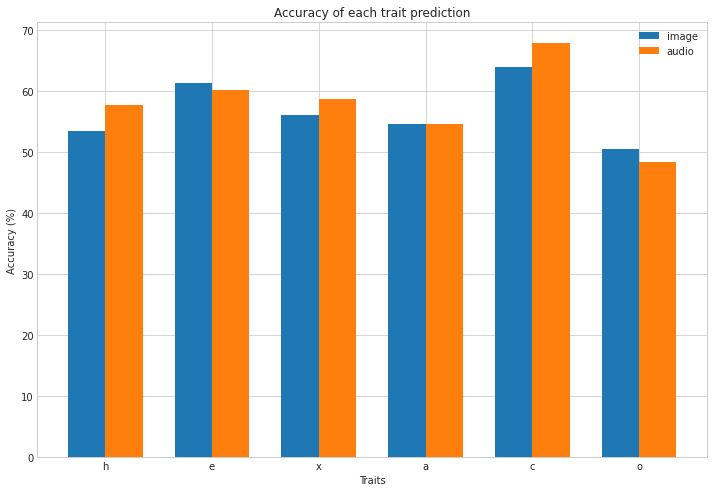

In [18]:
traits = ["h","e","x","a","c","o"]
width =.35

fig, ax = plt.subplots(figsize=(12,8))

ax.bar(np.arange(6)      ,result_image[best_image_idx,:,0] * 100, width=width, label='image', ecolor='black', capsize=10)
ax.bar(np.arange(6)+width,result_audio[best_audio_idx,:,0] * 100, width=width, label='audio', ecolor='black', capsize=10)

ax.set_xlabel('Traits')
ax.set_ylabel('Accuracy (%)')
ax.set_title('Accuracy of each trait prediction')
ax.set_xticks(np.arange(6) + width / 2)
ax.set_xticklabels(traits)
ax.legend()

plt.show()

In [19]:
print(f"On average, image accuracy is {round(result_image[best_image_idx,:,0].mean(),2)} and audio accuracy is {round(result_audio[best_audio_idx,:,0].mean(),2)}")
print(f"On average, image    score is {round(result_image[best_image_idx,:,1].mean(),2)} and audio    score is {round(result_audio[best_audio_idx,:,1].mean(),2)}")
print(f"On average, image      std is {round(result_image[best_image_idx,:,2].mean(),2)} and audio      std is {round(result_audio[best_audio_idx,:,2].mean(),2)}")

In [20]:
for index, trait in enumerate(traits):
    print(f"Image {trait}: Acc: {round(result_image[best_image_idx,index,0],2)} | score: {round(result_image[best_image_idx,index,1],2)} | std: score: {round(result_image[best_image_idx,index,2],2)}" )
    print(f"Audio {trait}: Acc: {round(result_audio[best_audio_idx,index,0],2)} | score: {round(result_audio[best_audio_idx,index,1],2)} | std: score: {round(result_audio[best_audio_idx,index,2],2)}" )
    print()
print(f"Image: Best Score is {best_image} at index {best_image_idx} with combination {best_image_comb}")
print(f"Audio: Best Score is {best_audio} at index {best_audio_idx} with combination {best_audio_comb}")

On average, image accuracy is 0.57 and audio accuracy is 0.58
On average, image    score is 0.57 and audio    score is 0.58
On average, image      std is 0.01 and audio      std is 0.02


Image h: Acc: 0.53 | score: 0.53 | std: score: 0.01
Audio h: Acc: 0.58 | score: 0.58 | std: score: 0.02

Image e: Acc: 0.61 | score: 0.61 | std: score: 0.01
Audio e: Acc: 0.6 | score: 0.6 | std: score: 0.01

Image x: Acc: 0.56 | score: 0.57 | std: score: 0.01
Audio x: Acc: 0.59 | score: 0.59 | std: score: 0.02

Image a: Acc: 0.55 | score: 0.55 | std: score: 0.01
Audio a: Acc: 0.55 | score: 0.55 | std: score: 0.02

Image c: Acc: 0.64 | score: 0.65 | std: score: 0.03
Audio c: Acc: 0.68 | score: 0.68 | std: score: 0.01

Image o: Acc: 0.5 | score: 0.5 | std: score: 0.01
Audio o: Acc: 0.48 | score: 0.49 | std: score: 0.01

Image: Best Score is 0.5682222222222222 at index 12 with combination ['Alpha' 'Beta']
Audio: Best Score is 0.5805555555555555 at index 12 with combination ['Alpha' 'Beta']
